<a href="https://colab.research.google.com/github/dyfzl/AI-JBNU/blob/main/%EC%9E%91%EA%B0%80%EC%9D%98_%EB%AC%B8%EC%B2%B4%EB%A5%BC_%ED%95%99%EC%8A%B5%ED%95%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%83%9D%EC%84%B1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install datasets

In [ ]:
import os

# WandB 비활성화
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive/')

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/소설작가분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/소설작가분류/test_x.csv')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# 데이터 확인
df = train
author_counts = df['author'].value_counts()
print(author_counts)

# 특정 작가(author=3)의 데이터 필터링 및 전처리
import re
def clean_text_preserve_style(text):
    text = re.sub(r"[^\w\s.,!?']", "", text)  # 특수문자 중 쉼표, 마침표 등 유지
    text = re.sub(r"\s+", " ", text).strip()  # 불필요한 공백 제거
    return text

author_data = df[df['author'] == 3]
author_data["text"] = author_data["text"].apply(clean_text_preserve_style)


author
3    15063
0    13235
2    11554
4     7805
1     7222
Name: count, dtype: int64


<ipython-input-40-6f4169ac472e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data["text"] = author_data["text"].apply(clean_text_preserve_style)


In [ ]:

# Hugging Face 모델 준비 (GPT-2)
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Padding token 추가
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))


Embedding(50257, 768)

In [ ]:

# 데이터셋 준비 및 전처리
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_data, eval_data = train_test_split(author_data, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_data[["text"]])
eval_dataset = Dataset.from_pandas(eval_data[["text"]])

def preprocess_data_with_labels(examples):
    inputs = tokenizer(
        examples["text"], max_length=512, truncation=True, padding="max_length"
    )
    inputs["labels"] = inputs["input_ids"]
    return inputs

train_dataset = train_dataset.map(preprocess_data_with_labels, batched=True)
eval_dataset = eval_dataset.map(preprocess_data_with_labels, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel

# Trainer 설정 및 학습
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=3e-5,
    warmup_steps=100,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 모델 학습
trainer.train()

# 모델과 토크나이저 저장
save_directory = "/content/fine_tuned_model"
trainer.save_model(save_directory)  # 학습된 모델 저장
tokenizer.save_pretrained(save_directory)  # 토크나이저 저장

print(f"Model and tokenizer saved to {save_directory}")

# 모델과 토크나이저 다시 불러오기
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)
model = GPT2LMHeadModel.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-45-4cdb61ba03b6>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
1000,0.360800,0.340833
2000,0.340100,0.335066
3000,0.340100,0.332032
4000,0.327900,0.330992
5000,0.335200,0.330349


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Model and tokenizer saved to /content/fine_tuned_model
Model and tokenizer loaded successfully!


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 저장된 경로 지정
save_directory = "./fine_tuned_model"

# 모델과 토크나이저 불러오기
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)
model = GPT2LMHeadModel.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully!")


Model and tokenizer loaded successfully!


In [ ]:
# 텍스트 생성
from transformers import pipeline

# 텍스트 생성 파이프라인 설정
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 테스트 프롬프트 정의
test_prompts = ["We", "The day was bright", "she"]

# 텍스트 생성 및 저장
generated_texts = [
    text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# 생성된 텍스트 출력
print("Generated Texts:")
for i, (prompt, generated) in enumerate(zip(test_prompts, generated_texts)):
    print(f"\nPrompt {i + 1}: {prompt}")
    print(f"Generated Text {i + 1}: {generated}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generated Texts:

Prompt 1: We
Generated Text 1: We took him, and there, there, and then, but I was here yesterday only to meet you again, not to let your heart be taken in. odin looked with horror and dread over his brother.

Prompt 2: The day was bright
Generated Text 2: The day was bright. The fire was burning bright. Darya odin, Darya odin, Darya odin went to bed at eight oclock. It began raining, and the heat and wind was unbearable. Her clothes were cold but she had to cover up the wetness by covering up her wet foot with a hot towel, covering with black linen, her hat, her gloves. They soaked quickly, and odin tried not to wet her feet. Her odin looked at her

Prompt 3: she
Generated Text 3: she thought of getting more and more agitated. His face looked pale and expression was rather grim, but when, at twentyfive the prince sat beside her, she could make out the words


In [ ]:
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

# 감정 분석 모델 설정
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# 유사 문장 찾기: 상위 8000개의 참조 문장을 비교
def find_related_sentences(prompts, data, top_n=8000):
    all_sentences = data['text'].tolist()
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(all_sentences)

    related_sentences = []
    for prompt in prompts:
        prompt_vector = vectorizer.transform([prompt])
        similarities = cosine_similarity(prompt_vector, sentence_vectors).flatten()
        top_indices = similarities.argsort()[-top_n:][::-1]
        top_related = [all_sentences[i] for i in top_indices]
        related_sentences.append(top_related)
    return related_sentences

# BLEU 점수 계산 함수
def calculate_bleu_with_multiple_references(generated, references):
    bleu_scores = []
    smoothing = SmoothingFunction().method1
    for gen_text, ref_texts in zip(generated, references):
        ref_tokens = [ref.split() for ref in ref_texts]  # 참조 문장 토큰화
        gen_tokens = gen_text.split()  # 생성된 텍스트 토큰화
        bleu_score = sentence_bleu(ref_tokens, gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(bleu_score)
    return bleu_scores

# 감정 분석 함수
def analyze_sentiments(texts):
    sentiment_mapping = {
        "POSITIVE": "Positive",
        "NEGATIVE": "Negative",
        "NEUTRAL": "Neutral"
    }
    sentiments = []
    for text in texts:
        sentiment = sentiment_analyzer(text)
        label = sentiment[0]['label']
        sentiments.append(sentiment_mapping.get(label, "Unknown"))
    return sentiments

# 테스트 프롬프트
test_prompts = ["We", "The day was bright", "she"]

# 텍스트 생성
generated_texts = [
    text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# 참조 문장 선택 (상위 8000개)
top_n = 8000
similar_sentences = find_related_sentences(test_prompts, eval_data, top_n)

# BLEU 점수 계산
bleu_scores = calculate_bleu_with_multiple_references(generated_texts, similar_sentences)

# 감정 분석 수행
generated_sentiments = analyze_sentiments(generated_texts)

# 상위 5개 참조 문장만 출력하도록 설정
top_5_sentences = [["\n".join(sentences[:5])] for sentences in similar_sentences]

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
    "Top Similar Sentences (Top 5)": [sentences[0] for sentences in top_5_sentences]
})

# 결과 출력
def display_results_with_sentiments(df):
    for index, row in df.iterrows():
        print(f"\n--- Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")
        print(f"Generated Text: {row['Generated Text']}")
        print(f"Sentiment: {row['Sentiment']}")
        print(f"BLEU Score: {row['BLEU Score']:.4f}")
        print("Top 5 Similar Sentences:")
        print(row["Top Similar Sentences (Top 5)"])
        print("-" * 50)

# BLEU 점수와 감정 분석 결과 출력
display_results_with_sentiments(results_df)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



--- Prompt 1 ---
Prompt: We
Generated Text: We have heard all the confessions and the confessions of women already in the house. odin made no such statement again.
Sentiment: Negative
BLEU Score: 0.2445
Top 5 Similar Sentences:
No, no we all want it.
I was standing at the gate with them... dont you remember? We have carried on our trade in that house for years past. We cure and prepare hides, we take work home... most of all I was vexed....
You think we may become friends?
I believe we can say _goodbye_!
You shall have some, too, when we get home.
--------------------------------------------------

--- Prompt 2 ---
Prompt: The day was bright
Generated Text: The day was bright and warm. The sun was shining brightly.
Sentiment: Positive
BLEU Score: 0.0564
Top 5 Similar Sentences:
But the prince only looked at the bright side he did not turn the coat and see the shabby lining.
The letter of the day before
Every day, every day! said the captain quickly, seeming cheered at the thought.
The

In [ ]:
# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Reference Texts": [", ".join(reference_texts)] * len(test_prompts),
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
})

# 결과 출력
print("Generated Text Analysis Results:")
print(results_df)

# 분석 함수 정의
def analyze_results(df):
    for index, row in df.iterrows():
        print(f"\n--- Analysis for Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")
        print(f"Generated Text: {row['Generated Text']}")
        print(f"Reference Texts: {row['Reference Texts'][:10]}...")  # 참조 텍스트 일부만 출력
        print(f"Sentiment: {row['Sentiment']}")
        print(f"BLEU Score: {row['BLEU Score']:.6f}")

        # BLEU 점수 평가
        if row["BLEU Score"] > 0.05:
            print("Analysis: The generated text is fairly similar to the reference texts.")
        elif row["BLEU Score"] > 0.02:
            print("Analysis: The generated text has some similarity to the reference texts.")
        else:
            print("Analysis: The generated text is quite different from the reference texts.")

        # 감정 분석 평가
        if row["Sentiment"] == "Positive":
            print("Sentiment Analysis: The generated text conveys a positive sentiment.")
        elif row["Sentiment"] == "Negative":
            print("Sentiment Analysis: The generated text conveys a negative sentiment.")
        elif row["Sentiment"] == "Neutral":
            print("Sentiment Analysis: The generated text conveys a neutral sentiment.")
        else:
            print("Sentiment Analysis: Unable to determine the sentiment.")

# 결과 분석 실행
analyze_results(results_df)


Generated Text Analysis Results:
               Prompt                                     Generated Text  \
0                  We  We have heard all the confessions and the conf...   
1  The day was bright  The day was bright and warm. The sun was shini...   
2                 she  she, she must have her own daughter, she cried...   

                                     Reference Texts Sentiment  BLEU Score  
0  He was in terrible haste, he snatched the keys...  Negative    0.244462  
1  He was in terrible haste, he snatched the keys...  Positive    0.056376  
2  He was in terrible haste, he snatched the keys...  Negative    0.228305  

--- Analysis for Prompt 1 ---
Prompt: We
Generated Text: We have heard all the confessions and the confessions of women already in the house. odin made no such statement again.
Reference Texts: He was in ...
Sentiment: Negative
BLEU Score: 0.244462
Analysis: The generated text is fairly similar to the reference texts.
Sentiment Analysis: The generated


--- Prompt 1 ---
Prompt: We
Generated Text: We have heard all the confessions and the confessions of women already in the house. odin made no such statement again.
Sentiment: Negative
BLEU Score: 0.2445
Top 5 Similar Sentences:
No, no we all want it.
I was standing at the gate with them... dont you remember? We have carried on our trade in that house for years past. We cure and prepare hides, we take work home... most of all I was vexed....
You think we may become friends?
I believe we can say _goodbye_!
You shall have some, too, when we get home.
--------------------------------------------------

--- Prompt 2 ---
Prompt: The day was bright
Generated Text: The day was bright and warm. The sun was shining brightly.
Sentiment: Positive
BLEU Score: 0.0564
Top 5 Similar Sentences:
But the prince only looked at the bright side he did not turn the coat and see the shabby lining.
The letter of the day before
Every day, every day! said the captain quickly, seeming cheered at the thought.
The

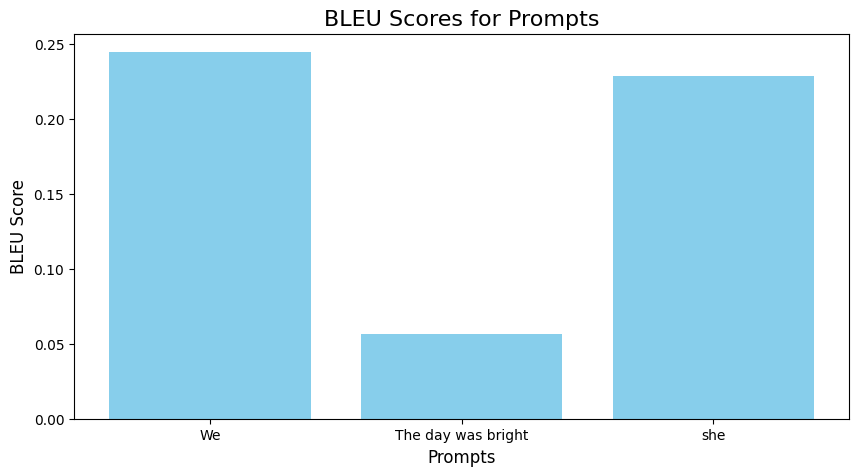

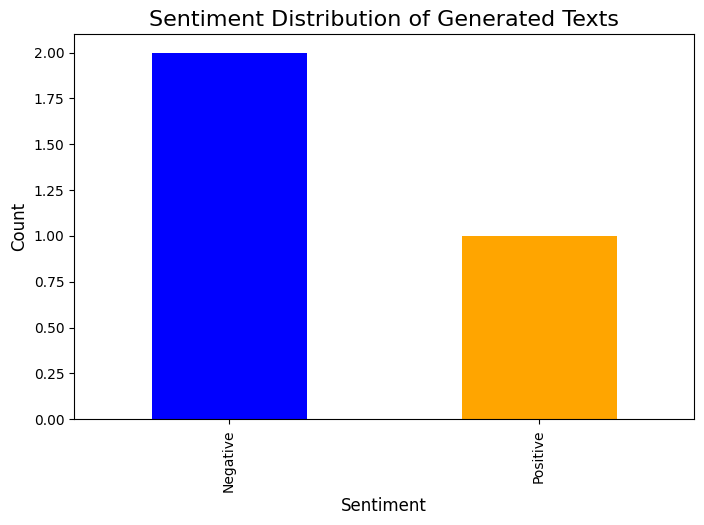

In [ ]:
# 시각화 함수
def visualize_results(df):
    # BLEU 점수 시각화
    plt.figure(figsize=(10, 5))
    plt.bar(df["Prompt"], df["BLEU Score"], color="skyblue")
    plt.title("BLEU Scores for Prompts", fontsize=16)
    plt.xlabel("Prompts", fontsize=12)
    plt.ylabel("BLEU Score", fontsize=12)
    plt.show()

    # 감정 분석 분포 시각화
    sentiment_counts = df["Sentiment"].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind="bar", color=["blue", "orange", "green"])
    plt.title("Sentiment Distribution of Generated Texts", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

# 참조 문장 선택 (상위 8000개)
top_n = 8000
similar_sentences = find_related_sentences(test_prompts, eval_data, top_n)

# 상위 5개 참조 문장만 추출
top_5_sentences = [
    "\n".join(sentences[:5])  # 상위 5개의 문장만 선택 후 줄바꿈으로 연결
    for sentences in similar_sentences
]

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
    "Top Similar Sentences (Top 5)": top_5_sentences  # 상위 5개 참조 문장 추가
})


# BLEU 점수와 관련 문장 출력
display_results_with_sentiments(results_df)

# 시각화 출력
visualize_results(results_df)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



--- Comparison for Prompt 1 ---
Prompt: We

Trained Model:
Generated Text: We have heard all the confessions and the confessions of women already in the house. odin made no such statement again.
Sentiment: Negative
BLEU Score: 0.2445

Untrained Model:
Generated Text: We

H.T.L.P.

The Lighthouse

The lighthouse was built in 1604 at what is now The Landing on the Gulf of St. Thomas in Louisiana. Located just off the shores of Lake Charles in Maine in the middle of the American Atlantic Ocean, its name is "Lighthouse Hill". It has been a popular spot among locals and visitors.

Lighthouse Hill is one of the oldest known lighthouse basins in Northern England and New Jersey.
Sentiment: Positive
BLEU Score: 0.1340
--------------------------------------------------

--- Comparison for Prompt 2 ---
Prompt: The day was bright

Trained Model:
Generated Text: The day was bright and warm. The sun was shining brightly.
Sentiment: Positive
BLEU Score: 0.0564

Untrained Model:
Generated Text: The d

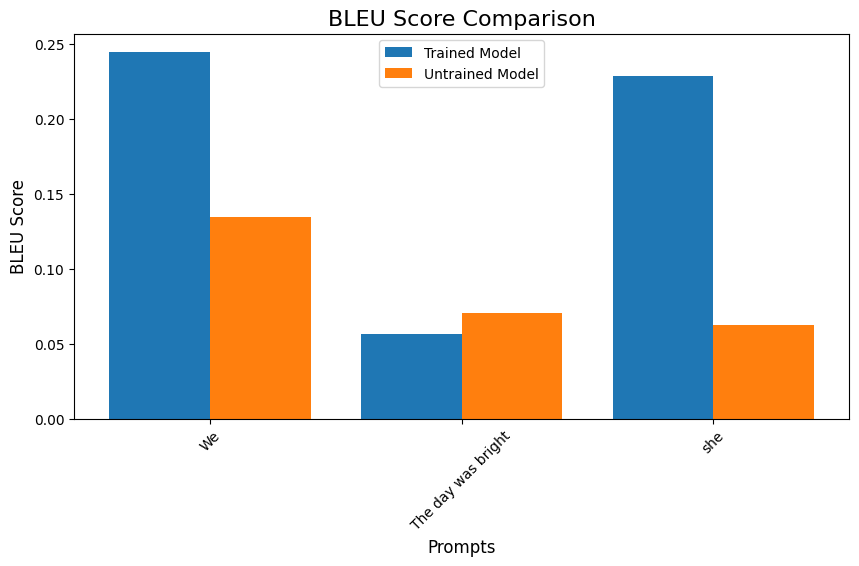

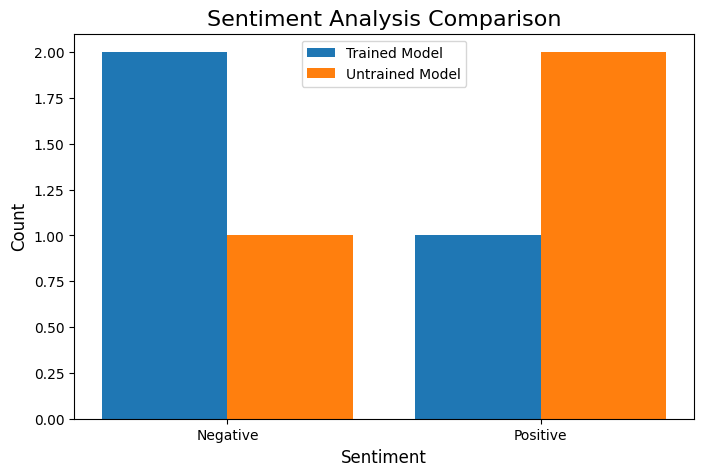

In [ ]:
# 문체 학습시키지 않은 기본 GPT-2 모델 불러오기
untrained_model = GPT2LMHeadModel.from_pretrained("gpt2")
untrained_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
untrained_tokenizer.pad_token = untrained_tokenizer.eos_token
untrained_model.resize_token_embeddings(len(untrained_tokenizer))

# 텍스트 생성 파이프라인 설정 (기본 모델)
untrained_text_generator = pipeline("text-generation", model=untrained_model, tokenizer=untrained_tokenizer)

# 테스트 프롬프트에 대해 텍스트 생성 (기본 모델)
untrained_generated_texts = [
    untrained_text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# BLEU 점수 계산 (기본 모델)
untrained_bleu_scores = calculate_bleu_with_multiple_references(untrained_generated_texts, similar_sentences)

# 감정 분석 수행 (기본 모델)
untrained_generated_sentiments = analyze_sentiments(untrained_generated_texts)

# 결과 데이터프레임 생성 (기본 모델)
untrained_results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": untrained_generated_texts,
    "Sentiment": untrained_generated_sentiments,
    "BLEU Score": untrained_bleu_scores,
})

# 학습된 모델과 비교 데이터프레임 통합
comparison_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Trained Generated Text": generated_texts,
    "Trained Sentiment": generated_sentiments,
    "Trained BLEU Score": bleu_scores,
    "Untrained Generated Text": untrained_generated_texts,
    "Untrained Sentiment": untrained_generated_sentiments,
    "Untrained BLEU Score": untrained_bleu_scores,
})

# 학습된 모델과 학습되지 않은 모델 비교 출력
def compare_models(df):
    for index, row in df.iterrows():
        print(f"\n--- Comparison for Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")

        print("\nTrained Model:")
        print(f"Generated Text: {row['Trained Generated Text']}")
        print(f"Sentiment: {row['Trained Sentiment']}")
        print(f"BLEU Score: {row['Trained BLEU Score']:.4f}")

        print("\nUntrained Model:")
        print(f"Generated Text: {row['Untrained Generated Text']}")
        print(f"Sentiment: {row['Untrained Sentiment']}")
        print(f"BLEU Score: {row['Untrained BLEU Score']:.4f}")
        print("-" * 50)

# 비교 결과 출력
compare_models(comparison_df)

# 시각화를 통해 비교
def visualize_comparison(df):
    # BLEU 점수 비교
    plt.figure(figsize=(10, 5))
    x = range(len(df["Prompt"]))
    plt.bar(x, df["Trained BLEU Score"], width=0.4, label="Trained Model", align="center")
    plt.bar([p + 0.4 for p in x], df["Untrained BLEU Score"], width=0.4, label="Untrained Model", align="center")
    plt.xticks([p + 0.2 for p in x], df["Prompt"], rotation=45)
    plt.title("BLEU Score Comparison", fontsize=16)
    plt.xlabel("Prompts", fontsize=12)
    plt.ylabel("BLEU Score", fontsize=12)
    plt.legend()
    plt.show()

    # 감정 분석 결과 비교
    trained_sentiment_counts = df["Trained Sentiment"].value_counts()
    untrained_sentiment_counts = df["Untrained Sentiment"].value_counts()

    sentiments = list(set(trained_sentiment_counts.index).union(set(untrained_sentiment_counts.index)))
    trained_counts = [trained_sentiment_counts.get(sent, 0) for sent in sentiments]
    untrained_counts = [untrained_sentiment_counts.get(sent, 0) for sent in sentiments]

    bar_width = 0.4
    x = range(len(sentiments))

    plt.figure(figsize=(8, 5))
    plt.bar(x, trained_counts, width=bar_width, label="Trained Model", align="center")
    plt.bar([p + bar_width for p in x], untrained_counts, width=bar_width, label="Untrained Model", align="center")
    plt.xticks([p + bar_width / 2 for p in x], sentiments)
    plt.title("Sentiment Analysis Comparison", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend()
    plt.show()

# 시각화 결과 출력
visualize_comparison(comparison_df)
